## setup

In [1]:
import pandas as pd

# prepare classes

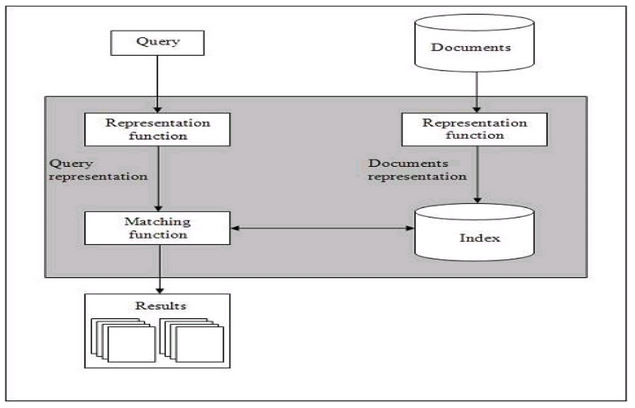

## preprocessor

نعرف كلاس المعالجة المسبقة للنصوص

الهدف الأساسي منه هو استخراج الكلمات

terms

In [2]:
import qalsadi.lemmatizer


In [3]:
import nltk
from nltk.tokenize import WhitespaceTokenizer, RegexpTokenizer, TreebankWordTokenizer

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...


True

In [4]:
#install the Arabic stop words library
import arabicstopwords.arabicstopwords as stp

#install the stop words from nltk lib:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from spellchecker import SpellChecker


In [7]:
#-preprocessor
class Preprocessor():



    @staticmethod
    def process(doc_or_query):
        s = doc_or_query
        s = Preprocessor.rmvUnwantedCharsEnglish(s)
        s = Preprocessor.correctSpelling(s)
        s = Preprocessor.normDocument(s)
        s = Preprocessor.lemmerDocument(s)
        s = Preprocessor.rmvstpwrds(s)        
        s = Preprocessor.tokenizeDocument(s)
        return s#Preprocessor.tokenizeDocument(s)

    @staticmethod
    def tokenizeDocument(sentence):
        return sentence.split(' ')
        
    @staticmethod
    def rmvUnwantedCharsEnglish(sentence):
        # إزالة كل الأحرف غير الإنجليزية والمسافات
        sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)
        return sentence

   
    @staticmethod
    def lemmerDocument(sentence):
        en_lemmer = WordNetLemmatizer()
        return " ".join([en_lemmer.lemmatize(i) for i in sentence.split()])
    
    #حذف ال stopword 
    @staticmethod
    def rmvstpwrds(sentence):
        terms = []
        stopWords = set(stopwords.words('english'))
        for term in sentence.split():
            if term.lower() not in stopWords:
                terms.append(term)
        return " ".join(terms)



   #توحيد اشكال الكلمات 
    @staticmethod
    def normDocument(sentence):
        replacements = {
            "successful": "success",
            "running": "run",
            "jumps": "jump",
            "better": "good",
            "best": "good"
            # يمكنك إضافة المزيد من الكلمات الشائعة هنا
        }
        
        for word, replacement in replacements.items():
            sentence = re.sub(r'\b' + word + r'\b', replacement, sentence)
        
        return sentence

    #تصحيح الكلمات الخاطئة 
    @staticmethod
    def correctSpelling(sentence):
        spell = SpellChecker(language='en')
        corrected_sentence = []
        for word in sentence.split():
            corrected_sentence.append(spell.correction(word))
        return " ".join(corrected_sentence)



`SpellChecker`
تستخدم خوارزمية مسافة لتحديد وتصحيح الكلمات الخاطئة إملائيًا عبر مقارنة الكلمة المدخلة بالكلمات الصحيحة في القاموس، وتختار الكلمة الأقرب التي تتطلب أقل عدد من التعديلات.

In [ ]:
#Preprocessor.tokenizeDocument("A successful team is a group of many hands but of one mind.")

In [ ]:
#Preprocessor.rmvUnwantedChars('hello world')

## Model

كلاس نموذج تخزين الوثائق ليتم استرجاعها لاحقا وفقا للاستعلام المطلوب

سنعتمد في هذه المحاضرة على نموذج

Term Document Incidence Matrix

In [9]:
import os 
import pickle
class IndexModel:
    def __init__(self, documents_df=None, index_file=None, meta_file=None):
        
        if index_file is None and meta_file is None and documents_df is not None:
            self.create_new_index(documents_df)
        elif index_file is not None and meta_file is not None:
            self.read_index(index_file, meta_file)
        else:
            raise ValueError("Provide either documents_df for creating a new index or index_file and meta_file for reading an existing index")

    def create_new_index(self, documents_df):
        termdoc = documents_df.to_dict('list')
        unique_terms = set()
        doc_ids = termdoc['id']

        for terms in termdoc['ntext']:
            unique_terms.update(terms)

        term_ids = sorted(list(unique_terms))
        term_to_id = {term: idx for idx, term in enumerate(term_ids)}
        doc_to_id = {doc_id: idx for idx, doc_id in enumerate(doc_ids)}

        self._index_matrix = [[0 for _ in range(len(doc_ids))] for _ in range(len(term_ids))]

        for i, terms in enumerate(termdoc['ntext']):
            for term in terms:
                term_idx = term_to_id[term]
                doc_idx = doc_to_id[doc_ids[i]]
                self._index_matrix[term_idx][doc_idx] = 1

        self._term_to_id = term_to_id
        self._doc_to_id = doc_to_id

    def get_term_vector(self, term):
        if term in self._term_to_id:
            term_idx = self._term_to_id[term]
            return self._index_matrix[term_idx]
        else:
            return [0 for _ in range(len(self._doc_to_id))]

    def read_index(self, index_file, meta_file):
        with open(index_file, 'rb') as f:
            self._index_matrix = pickle.load(f)

        with open(meta_file, 'rb') as f:
            meta_data = pickle.load(f)

        self._term_to_id = meta_data['term_to_id']
        self._doc_to_id = meta_data['doc_to_id']

    def save_index(self, index_path, meta_path):
        with open(index_path, 'wb') as f:
            pickle.dump(self._index_matrix, f)

        meta_data = {'term_to_id': self._term_to_id, 'doc_to_id': self._doc_to_id}
        with open(meta_path, 'wb') as f:
            pickle.dump(meta_data, f)


## Retriever

ولاسترجاع الوثائق الموافقة لكلمات الاستعلام, سنقوم ببناء كلاس الاسترجاع

سنتعرف على الاسترجاع البولياني لهذه المحاضرة

In [10]:

class Retriever:
    def __init__(self):
        self._terms_operator = ['&', '|', '~']

    def boolean_operator_processing(self, bop, prevV, nextV=None):
        if bop == "&":
            return [a & b for a, b in zip(prevV, nextV)]
        elif bop=="|" :
            return [a | b for a, b in zip(prevV, nextV)]
        elif bop == "~":
            return [1-a for a in prevV]

    def retrieve(self, query_terms, index_model):
        ret_docs = []
        bitwiseop=""
        result=[]
        has_previous_term=False
        has_not_operation=False
        inc_vec_prev=[]
        inc_vec_next=[]
        for term in query_terms:
            if term not in self._terms_operator:
                if has_not_operation:
                    if has_previous_term:
                        inc_vec_next=self.boolean_operator_processing("~",index_model.term_incidence_vector(term),inc_vec_next)
                    else :
                        inc_vec_prev=self.boolean_operator_processing("~",index_model.term_incidence_vector(term),inc_vec_next)
                        result=inc_vec_prev
                    has_not_operation=False
                elif has_previous_term:
                    inc_vec_next=index_model.term_incidence_vector(term)
                else:
                    inc_vec_prev=index_model.term_incidence_vector(term)
                    result= inc_vec_prev
                    has_previous_term=True
            elif term =="~":
                has_not_operation=True
            else:
                bitwiseop=term

            #----------
            if len(inc_vec_next)!= 0  :
                result = self.boolean_operator_processing(bitwiseop,inc_vec_prev,inc_vec_next)
                inc_vec_prev=result
                has_previous_term=True
                inc_vec_next= []

        #-----
        for i,res in enumerate(result):
            if res == 1:
                ret_docs.append({'id':i, 'score':res})
        ret_docs = pd.DataFrame(ret_docs, columns=['id', 'score', 'content']).sort_values(by=['score'], ascending=False)
        return ret_docs



## Search engine

الان سنعرف كلاس محرك استرجاع المعلومات الذي يضم نموذج النظام ونموذج الاسترجاع

In [15]:
class SearchEngine:
    def __init__(self, preprocessor, retriever, documents, index_file=None, meta_file=None):
        self.preprocessor = preprocessor
        self.retriever = retriever
        self.documents = None
        self.model = None
        self.rebuild(documents, index_file, meta_file)

    def rebuild(self, documents, index_file=None, meta_file=None):
        self.documents = documents
        self.documents['ntext'] = self.documents['text'].apply(self.preprocessor.process)
        

        if index_file and meta_file and os.path.exists(index_file) and os.path.exists(meta_file):
            self.model = IndexModel(index_file=index_file, meta_file=meta_file)
            print(f"Index loaded from {index_file}")
            print(f"Meta data loaded from {meta_file}")
        else:
            self.model = IndexModel(documents_df=documents)
            if index_file and meta_file:
                self.model.save_index(index_file, meta_file)
                print(f"Index saved to {index_file}")
                print(f"Meta data saved to {meta_file}")

    def querying(self, query):
        query_terms = self.preprocessor.process(query)
        term_vectors = [self.model.get_term_vector(term) for term in query_terms]

        if not term_vectors:
            return pd.DataFrame(columns=['id', 'score', 'content'])

        scores = [sum(doc) for doc in zip(*term_vectors)]
        results = [{'id': doc_id, 'score': score} for doc_id, score in zip(self.model._doc_to_id.keys(), scores) if score > 0]

        if not results:
            return pd.DataFrame(columns=['id', 'score', 'content'])

        docs_res = pd.DataFrame(results).sort_values(by='score', ascending=False)
        docs_res['content'] = docs_res.apply(lambda row: self.documents[self.documents['id'] == row['id']]['text'].iloc[0], axis=1)
        return docs_res

    def display_documents(self):
        return self.documents


## Dataset

مجموعة البيانات التي سنطبق عليها هي معلومات عامة حول الجغرافيا

In [16]:

def loadDocuments(directory):
    documents = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                content = file.read()
                doc_id = os.path.splitext(filename)[0]
                documents.append([doc_id, content])

    documents_df = pd.DataFrame(documents, columns=['id', 'text'])
    return documents_df

# doc path
directory = 'Project1_datacoll'  
documents_df = loadDocuments(directory)

# index path
index_file_path = 'myindex.index'
meta_file_path = 'idim.meta'


# let's start

In [17]:
search_engine = SearchEngine(Preprocessor(), Retriever(), documents_df, index_file=index_file_path, meta_file=meta_file_path)


BadZipFile: File is not a zip file

In [ ]:
search_engine.display_documents()


,id,text,ntext
0,African,"﻿If you want to go fast, go alone. If you want...","[﻿If, you, want, to, go, fast,, go, alone., If..."
1,Bill,﻿A successful team is a group of many hands bu...,"[﻿A, successful, team, is, a, group, of, many,..."
2,Funny,﻿A team is like a pack of wolves—always hungry...,"[﻿A, team, is, like, a, pack, of, wolves—alway..."
3,Helen,"﻿Alone, we can do so little; together, we can ...","[﻿Alone,, we, can, do, so, little;, together,,..."
4,Henry,﻿Coming together is a beginning. Keeping toget...,"[﻿Coming, together, is, a, beginning., Keeping..."


In [ ]:
search_engine.querying("success fast")


,id,score,content
0,Funny,1,﻿A team is like a pack of wolves—always hungry...


In [ ]:
search_engine.querying("success together")


,id,score,content
0,Funny,1,﻿A team is like a pack of wolves—always hungry...
1,Henry,1,﻿Coming together is a beginning. Keeping toget...
